# Задание №2. Деинтерлейсинг

## Описание

Предлагается реализовать нейросетевой алгоритм деинтерлейсинга.

**Требования**:
* модель реализована на фреймворке PyTorch
* обучение происходило _только_ на предоставленной обучающей выборке (но можно использовать разумное размножение выборки)

### Общие требования

* соблюдать [кодекс чести](https://communitystandards.stanford.edu/policies-and-guidance/honor-code). Виновные будут найдены и наказаны.

## Оценивание

1. Каждый участник может представить не более 1 алгоритма для финального тестирования

2. Тестирование будет проводиться на закрытой тестовой выборке, содержащей N (N < 10) тестовых видео

3. В качестве метрик будут использованы:
    * PSNR
    * SSIM
    
4. По итогам тестирования будет составлена общая таблица результатов по каждой из метрик

5. Место алгоритма определяется по формуле: $Place_{algo} = \frac{Place_{PSNR} + Place_{SSIM}}{2}$

6. Баллы за алгоритм зависят от его места: $Score_{algo} = score(Place_{algo})$

7. Баллы участника получаются из баллов за предоставленный алгоритм: $Score_{stud} = Score_{neural}^{stud}$

## Повторение

* [Статья на Хабре](https://habr.com/en/post/51201/) про развёртки
* [Статья на Хабре](https://habr.com/en/post/61822/) про методы деинтерлейсинга

_Прогрессивная развёртка (построчная развёртка)_ — способ трансляции и хранения видео, при котором в каждом кадре все строки отображаются последовательно.

_Интерлейсинг (чересстрочная развёртка)_ — способ трансляции и хранения видео, при котором каждый кадр разбивается на два поля (чётное и нечётное).

<img src="extra/interlacing-scheme.gif" width="300"/>

* _Top Field (Odd Field, чётное поле)_ — чётные строки кадра
* _Bottom Field (Even Field, нечётное поле)_ — нечётные строки кадра

То, какое поле (чётное или нечётное) отвечает за более ранний момент времени — настраиваемый параметр. Обычно чётное поле по времени не позже нечётного

При интерлейсинге:
* частота кадров *увеличивается в 2 раза* относительно исходного видео в прогрессивной развёртке
* разрешение каждого отдельного кадра *уменьшается в 2 раза*

Это происходит из-за того, что в каждый момент времени на экране отображается только один полукадр.

![interlaced-vs-progressive](extra/interlaced-vs-progressive.jpg)

_Деинтерлейсинг_ — преобразование из чересстрочной развёртки в прогрессивную без потери частоты кадров.

## Deep Deinterlacer

Будем реализовывать статью https://arxiv.org/abs/1708.00187

### 0. Скачаем данные

#### Tiny Dataset [0.5 GB]

In [ ]:
# !wget https://titan.gml-team.ru://courses/2019-spring/deint/tiny_data.zip

In [ ]:
# !unzip -d data tiny_data.zip

#### Full Dataset [4.3 GB]

In [ ]:
# !wget https://titan.gml-team.ru://courses/2019-spring/deint/data.zip

In [ ]:
# !unzip -d data data.zip

### 1. Устанавливаем библиотеки

In [ ]:
# !pip install matplotlib numpy pillow scikit-image torch tqdm tensorboard

In [1]:
import copy

import torch
import os
from torch import nn
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import skimage
from tqdm.notebook import tqdm
import cv2 as cv

from pathlib import Path

### 2. Создадим классы для подготовки и загрузки данных

Самый простой случай:

$X_k = \langle I_{n}^{odd}, I_{n+1}^{even} \rangle$

$y_k = \langle I_{n}^{even}, I_{n+1}^{odd} \rangle$

In [2]:
class MyDataset(torch.utils.data.IterableDataset):
    def __init__(self, path, target_size=(1080, 1080), shuffle=False):
        self.target_height, self.target_width = target_size
        self.shuffle = shuffle
        root_dir = Path(path)
        
        # Directories containing sequences
        directories = sorted(filter(lambda f: f.is_dir(), root_dir.iterdir()))
        
        self._frames_paths_pairs = []

        for frames_dir in directories:
            # Order frames names alphabetically
            frames_paths = sorted(frames_dir.iterdir())
            # Empty directory
            if not frames_paths:
                continue
            # If necessary, you can use more than two frames
            for frames_paths_pair in zip(frames_paths[::2], frames_paths[1::2]):
                self._frames_paths_pairs.append(frames_paths_pair)
    
    def _create_records(self, frames_seq):
        # frames_seq : sequential frames, read from paths of self._frames_paths_pairs
        # If necessary, you can use more than two frames by changing self._frames_paths_pairs
        height, width = frames_seq[0].shape[: 2]
        patch_shape = (self.target_height, self.target_width, 3)

        # Crop the rest of the frames
        height -= height % self.target_height
        width -= width % self.target_width

        # Cut the frames into patches
        first_frame_patches, second_frame_patches = (
            skimage.util.view_as_blocks(
                frame[: height, : width],
                patch_shape
            ).reshape((-1, *patch_shape))
            for frame in frames_seq
        )

        # Separate odd and even rows of the patches
        first_frame_patches_odd_rows = first_frame_patches[:, ::2]
        first_frame_patches_even_rows = first_frame_patches[:, 1::2]
        second_frame_patches_odd_rows = second_frame_patches[:, ::2]
        second_frame_patches_even_rows = second_frame_patches[:, 1::2]

        # Combine an input of I^{odd}_{t} and I^{even}_{t+1} for every patch
        input_patches = np.zeros_like(first_frame_patches)
        input_patches[:, ::2] = first_frame_patches_odd_rows
        input_patches[:, 1::2] = second_frame_patches_even_rows
        # The first ground truth output is I^{even}_{t}
        output_cur_patches = first_frame_patches_even_rows
        # The second ground truth output is I^{odd}_{t+1}
        output_next_patches = second_frame_patches_odd_rows

        records = zip(input_patches, zip(output_cur_patches, output_next_patches))
        return records

    def __iter__(self):
        """Yields the input and the outputs for a NN
        
        Returns
        -------
            record : (np.array, (np.array, np.array))
        """

        if self.shuffle:
            np.random.shuffle(self._frames_paths_pairs)

        for frames_paths_pair in self._frames_paths_pairs:
            frames_seq = tuple(
                np.array(Image.open(frame_path), dtype=np.float32) / 255.
                for frame_path in frames_paths_pair
            )
            # (first_frame, second_frame)
            # Here you can apply some full frame augmentations
            records = list(self._create_records(frames_seq))
            if self.shuffle:
                np.random.shuffle(records)

            for record in records:
                # (merged_patch, (gt_first, gt_second))
                # Here you can apply some record augmentations
                yield record

In [36]:
dataset_trn = MyDataset('./tiny_data/tiny_data/trn')
dataset_vld = MyDataset('./tiny_data/tiny_data/vld')

BATCH_SIZE = 4

dataloader_trn = torch.utils.data.DataLoader(dataset_trn,
                                             batch_size=BATCH_SIZE,
                                             num_workers=0)  # only single-process loading supported
dataloader_vld = torch.utils.data.DataLoader(dataset_vld,
                                             batch_size=BATCH_SIZE,
                                             num_workers=0)  # only single-process loading supported

In [260]:
batch = next(iter(dataloader_trn))

2
2
2
2
2
2
2
2


TypeError: Invalid shape (4, 1080, 1080, 3) for image data

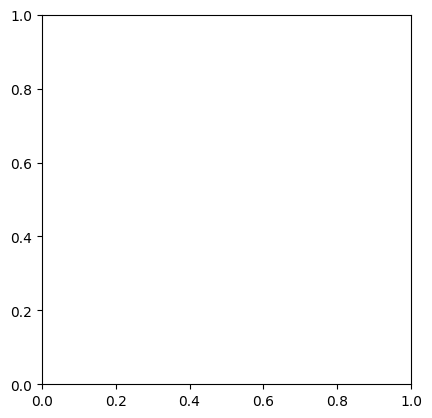

In [239]:
plt.imshow(batch[0][1])

### 3. Создадим класс нашей модели

Документация PyTorch: https://pytorch.org/docs/stable/index.html

Следующая ячейка должна содержать архитектуру вашей модели.

 - Комментарий `# GRADED CELL: ...` должен быть первым комментарием в клетке. Его нельзя изменять.
 - Эта клетка должен быть в единственном экземпляре.
 - Оцениваться будет только код, написанный внутри класса `Model`.

In [502]:
# GRADED CELL: Model

class Model(nn.Module):
    def __init__(self):
        """Initializes model's architecture.
        Assumes an input to be (3, height, width) tensor
        """
        super(Model, self).__init__()
        # A common part of the models predicting missing
        # rows of the current and the next frames
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=(3, 3), padding=1)
        self.relu1_1 = nn.ReLU()
        self.conv2_1 = nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1)
        self.relu2_1 = nn.ReLU()
        self.conv3_1 = nn.Conv2d(64, 32, kernel_size=(3, 3), padding=1)

        self.conv1_2 = nn.Conv2d(3, 64, kernel_size=(3, 3), padding=1)
        self.relu1_2 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1)
        self.relu2_2 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(64, 32, kernel_size=(3, 3), padding=1)
        # I^{even}_{t}
        self.conv4_1 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1)
        self.conv4_2 = nn.Conv2d(32, 3, kernel_size=(3, 3), padding=1, stride=(2, 1))
        self.sigmoid4_2 = nn.Sigmoid()
        # I^{odd}_{t+1}
        self.conv5_1 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1)
        self.conv5_2 = nn.Conv2d(32, 3, kernel_size=(3, 3), padding=1, stride=(2, 1))
        self.sigmoid5_2 = nn.Sigmoid()

    def forward(self, x):
        """Mapping from input to outputs

        Parameters
        ----------
            x : torch.tensor
                x is (batch_size, height, width, 3) matrix — model's input
                combined of I^{odd}_{t} and I^{even}_{t+1}

        Returns
        -------
            cur_even : torch.tensor
                first model output — I^{even}_t prediction
            next_odd : torch.tensor
                second model output — I^{odd}_{t+1} prediction
        """
        # Make the channel dimension in images go first
        # so that PyTorch processes it correctly

        cur_even = x[:, 0].permute(0, 3, 1, 2)
        next_odd = x[:, 1].permute(0, 3, 1, 2)


        cur_even = self.conv1_1(cur_even)
        cur_even = self.relu1_1(cur_even)
        cur_even = self.conv2_1(cur_even)
        cur_even = self.relu2_1(cur_even)
        cur_even = self.conv3_1(cur_even)

        next_odd = self.conv1_2(next_odd)
        next_odd = self.relu1_2(next_odd)
        next_odd = self.conv2_2(next_odd)
        next_odd = self.relu2_2(next_odd)
        next_odd = self.conv3_2(next_odd)
        # A branch that predicts I^{even}_{t}

        cur_even = self.conv4_1(cur_even)
        cur_even = self.conv4_2(cur_even)
        cur_even = self.sigmoid4_2(cur_even)
        # Put the channel dimension back
        cur_even = cur_even.permute(0, 2, 3, 1)

        # A branch that predicts I^{odd}_{t+1}
        next_odd = self.conv5_1(next_odd)
        next_odd = self.conv5_2(next_odd)
        next_odd = self.sigmoid5_2(next_odd)
        # Put the channel dimension back
        next_odd = next_odd.permute(0, 2, 3, 1)

        return cur_even, next_odd

### 4. Обучим заданную модель

__Пайплайн обучения__:
* Определить __таргет__. В нашей задаче это недостающие строки двух последовательных кадров
* Определить __функцию потерь (loss)__. У нас всё просто: хочется, чтобы изображения мало отличались друг от друга, поэтому используем MSE между таргетом и предсказанием сети.
* Выбрать __оптимизатор__. Задача не из простых, но если хочется, чтобы всё быстро полетело, то лучше всего `Adam`.

Шпаргалка по отпимизаторам: https://habr.com/ru/post/318970/

In [503]:
# Use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize a model
model = Model()
# Move its parameters to the GPU
model.to(device)

print(device)
print(model)
print("Number of parameters:", sum([p.numel() for p in model.parameters()]))

cpu
Model(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_1): ReLU()
  (conv2_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU()
  (conv3_1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU()
  (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU()
  (conv3_2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(32, 3, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
  (sigmoid4_2): Sigmoid()
  (conv5_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_2): Conv2d(32, 3, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
  (sigmoid5_2): Sigmoid()
)
Number of parameters: 134598


In [461]:
# Define a loss function
criterion = nn.MSELoss().to(device)
# Pick Adam algorithm as an optimizer
optimizer = torch.optim.Adam(model.parameters())

ValueError: optimizer got an empty parameter list

In [40]:
def train_model(model, epochs):
    """Trains the given model with the given number of epochs
    
    Parameters
    ----------
        model : Model
        epochs : int
            number of epochs to train the model
    """
    writer = SummaryWriter()

    for epoch in range(1, epochs+1):
        print(f"Epoch {epoch}/{epochs}:", flush=True)
        # Recalculate train loss on every sample using a moving average
        moving_avg_loss = 0.0
        train_losses = []
        
        ##################
        ### TRAIN LOOP ###
        ##################
        with tqdm() as batch_bar:
            for i, data in enumerate(dataloader_trn):
                inputs, gt_outputs = data
                # Move data to GPU
                inputs = inputs.to(device)
                gt_outputs = list(map(lambda x: x.to(device), gt_outputs))
                
                # Forward pass
                outputs = model(inputs)
                # Calculate loss, make a backward pass and update the parameters of the model
                loss = criterion(outputs[0], gt_outputs[0]) + criterion(outputs[1], gt_outputs[1])
                # Set to zero the parameter gradients for the current batch
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Calculate moving average loss
                moving_avg_loss = loss.item() if i == 0 else (0.99 * moving_avg_loss + 0.01 * loss.item())
                
                # Save train batch loss
                train_losses.append(loss.item())
                batch_bar.set_postfix_str(f"\tloss = {moving_avg_loss :.8f}")
                batch_bar.update()
                
        writer.add_scalar('Loss/train', np.mean(train_losses), epoch)
        print(f"Train loss: {np.mean(train_losses)}\n", flush=True)
        
        #######################
        ### VALIDATION LOOP ###
        #######################
        val_losses = []
        # Freeze model params for validation
        model.eval()
        with torch.no_grad():
            with tqdm() as batch_bar:
                for i, data in enumerate(dataloader_vld):
                    inputs, gt_outputs = data
                    inputs = inputs.to(device)
                    gt_outputs = list(map(lambda x: x.to(device), gt_outputs))
                    outputs = model(inputs)
                    loss = criterion(outputs[0], gt_outputs[0]) + criterion(outputs[1], gt_outputs[1])
                    val_losses.append(loss.item())
                    batch_bar.set_postfix_str(f"\tval loss = {loss.item() :.8f}")
                    batch_bar.update()

        writer.add_scalar('Loss/val', np.mean(val_losses), epoch)
        print(f"Validation loss: {np.mean(val_losses)}\n", flush=True)

        # Unfreeze model params for training
        model.train()
        
    print("Finished training!")

In [35]:
train_model(model=model, epochs=5)

Epoch 1/5:


0it [00:00, ?it/s]

AttributeError: 'Model' object has no attribute 'conv1'

In [33]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir runs

Launching TensorBoard...

### 5. Посмотрим на выход модели

In [447]:
def evaluate(model, interlaced_image):
    with torch.no_grad():
        # Add batch dimension and wrap it into a tensor on the GPU
        model_input = torch.tensor(interlaced_image[np.newaxis, ...], device=device)
        # Predict 
        current_even, next_odd = model(model_input)

        current_even = current_even.cpu().numpy()[0]
        next_odd = next_odd.cpu().numpy()[0]

        first = np.zeros_like(interlaced_image)
        first[::2] = interlaced_image[::2]
        first[1::2] = current_even

        second = np.zeros_like(interlaced_image)
        second[1::2] = interlaced_image[1::2]
        second[::2] = next_odd

        return first, second

In [629]:
model = torch.load("model.pth", map_location=torch.device('cpu')).to("cpu").eval()

In [630]:
def evaluate1(model, interlaced_image):
    with torch.no_grad():
        model_input = torch.tensor(interlaced_image[np.newaxis, ...], device=device)
        # Predict

        size_of_blocks = (8, 8)
        size_of_domain = (64, 64)

        x = model_input.permute(0, 3, 1, 2)
        cur_even = torch.from_numpy(np.zeros_like(x.cpu()))
        next_odd = torch.from_numpy(np.zeros_like(x.cpu()))
        cur_even[:, :, 1::2] = x[:, :, 1::2]
        next_odd[:, :, ::2] = x[:, :, ::2]

        batch_size = x.size(dim=0)
        height = x.size(dim=2)
        width = x.size(dim=3)
        height_halves = height // 2
        mv_height = height_halves // size_of_blocks[0]
        mv_width = width // size_of_blocks[1]
        with torch.no_grad():
            cur = x[:, :, ::2]
            next = x[:, :, 1::2]
            for batch in range(batch_size):
                for i in range(mv_height):
                    for j in range(mv_width):
                        #
                        block = cur[batch, :, i * size_of_blocks[0]:(i + 1) * size_of_blocks[0],
                                j * size_of_blocks[1]:(j + 1) * size_of_blocks[1]]
                        domain = next[batch,
                                 :,
                                 max(0, i * size_of_blocks[0] + size_of_blocks[0]//2 - size_of_domain[0]):
                                 min(height_halves, (i + 1) * size_of_blocks[0] - size_of_blocks[0]//2 + size_of_domain[0]),
                                 max(0, j * size_of_blocks[1] + size_of_blocks[1]//2 - size_of_domain[1]):
                                 min(width, (j + 1) * size_of_blocks[1] - size_of_blocks[1]//2 + size_of_domain[1])
                                 ]
                        cmp_res = cv.matchTemplate(torch.Tensor.numpy(domain.permute(1, 2, 0).cpu()),
                                                   torch.Tensor.numpy(block.permute(1, 2, 0).cpu()),
                                                   cv.TM_SQDIFF)
                        i_r, j_r = cmp_res.argmin() // cmp_res[0].size, cmp_res.argmin() % cmp_res[0].size
                        next_odd[batch, :,
                        2 * i * size_of_blocks[0] + 1 : 2 * (i + 1) * size_of_blocks[0] + 1 : 2,
                        j * size_of_blocks[1]: (j + 1) * size_of_blocks[1]] = \
                            domain[:,
                            i_r : i_r + size_of_blocks[0],
                            j_r : j_r + size_of_blocks[1]]

                        block = next[batch, :, i * size_of_blocks[0]:(i + 1) * size_of_blocks[0],
                                j * size_of_blocks[1]:(j + 1) * size_of_blocks[1]]
                        domain = cur[batch,
                                 :,
                                 max(0, i * size_of_blocks[0] + size_of_blocks[0]//2 - size_of_domain[0]):
                                 min(height_halves, (i + 1) * size_of_blocks[0] - size_of_blocks[0]//2 + size_of_domain[0]),
                                 max(0, j * size_of_blocks[1] + size_of_blocks[1]//2 - size_of_domain[1]):
                                 min(width, (j + 1) * size_of_blocks[1] - size_of_blocks[1]//2 + size_of_domain[1])
                                 ]
                        cmp_res = cv.matchTemplate(torch.Tensor.numpy(domain.permute(1, 2, 0).cpu()),
                                                   torch.Tensor.numpy(block.permute(1, 2, 0).cpu()),
                                                   cv.TM_SQDIFF)
                        i_r, j_r = cmp_res.argmin() // cmp_res[0].size, cmp_res.argmin() % cmp_res[0].size
                        cur_even[batch, :,
                        2 * i * size_of_blocks[0] : 2 * (i + 1) * size_of_blocks[0] : 2,
                        j * size_of_blocks[1]: (j + 1) * size_of_blocks[1]] = \
                            domain[:,
                            i_r : i_r + size_of_blocks[0],
                            j_r : j_r + size_of_blocks[1]]
                for i in range(mv_height * size_of_blocks[0], height // 2):
                    next_odd[batch, :, 2 * i + 1, :] = next_odd[batch, :, 2 * i, :]
                    cur_even[batch, :, 2 * i, :] = cur_even[batch, :, 2 * i - 1, :]

        cur_even = cur_even.permute(0, 2, 3, 1)
        next_odd = next_odd.permute(0, 2, 3, 1)
        #return cur_even.cpu().numpy()[0], next_odd.cpu().numpy()[0]
        input_patches = torch.nn.utils.rnn.pad_sequence([next_odd, cur_even])
        input_patches.permute(1, 0, 2, 3, 4)
        current_even, next_odd = model(input_patches)

        current_even = current_even.cpu().numpy()[0]
        next_odd = next_odd.cpu().numpy()[0]

        first = np.zeros_like(interlaced_image)
        first[::2] = interlaced_image[::2]
        first[1::2] = current_even

        second = np.zeros_like(interlaced_image)
        second[1::2] = interlaced_image[1::2]
        second[::2] = next_odd
        return first, second

In [631]:
test_image = np.array(Image.open('C:/Users/doodo/Desktop/ИИТ/Task2/tiny_data/test/interlace/0/00000.png'), dtype=np.float32) / 255.
gt_image = np.array(Image.open('C:/Users/doodo/Desktop/ИИТ/Task2/tiny_data/test/gt/0/00000.png'), dtype=np.float32) / 255.

In [599]:
test_image = np.array(Image.open('C:/Users/doodo/Desktop/ИИТ/Task2/tiny_data/test/interlace/0/00000.png'),
                      dtype=np.float32) / 255.
test_image = np.array([test_image, test_image])
x = torch.tensor(test_image)


# Motion
size_of_blocks = (4, 4)
size_of_domain = (16, 16)

x = x.permute(0, 3, 1, 2)
cur_even = torch.from_numpy(np.zeros_like(x))
next_odd = torch.from_numpy(np.zeros_like(x))
cur_even[:, :, 1::2] = x[:, :, 1::2]
next_odd[:, :, ::2] = x[:, :, ::2]

batch_size = x.size(dim=0)
height = x.size(dim=2)
width = x.size(dim=3)
height_halves = height // 2
mv_height = height_halves // size_of_blocks[0]
mv_width = width // size_of_blocks[1]
with torch.no_grad():
    cur = x[:, :, ::2]
    next = x[:, :, 1::2]
    for batch in range(batch_size):
        for i in tqdm(range(mv_height)):
            for j in range(mv_width):
                #
                block = cur[batch, :, i * size_of_blocks[0]:(i + 1) * size_of_blocks[0],
                        j * size_of_blocks[1]:(j + 1) * size_of_blocks[1]]
                domain = next[batch,
                         :,
                         max(0, i * size_of_blocks[0] + size_of_blocks[0]//2 - size_of_domain[0]):
                         min(height_halves, (i + 1) * size_of_blocks[0] - size_of_blocks[0]//2 + size_of_domain[0]),
                         max(0, j * size_of_blocks[1] + size_of_blocks[1]//2 - size_of_domain[1]):
                         min(width, (j + 1) * size_of_blocks[1] - size_of_blocks[1]//2 + size_of_domain[1])
                         ]
                cmp_res = cv.matchTemplate(torch.Tensor.numpy(domain.permute(1, 2, 0)),
                                           torch.Tensor.numpy(block.permute(1, 2, 0)),
                                           cv.TM_SQDIFF)
                i_r, j_r = cmp_res.argmin() // cmp_res[0].size, cmp_res.argmin() % cmp_res[0].size
                next_odd[batch, :,
                2 * i * size_of_blocks[0] + 1 : 2 * (i + 1) * size_of_blocks[0] + 1 : 2,
                j * size_of_blocks[1]: (j + 1) * size_of_blocks[1]] = \
                    domain[:,
                    i_r : i_r + size_of_blocks[0],
                    j_r : j_r + size_of_blocks[1]]

                block = next[batch, :, i * size_of_blocks[0]:(i + 1) * size_of_blocks[0],
                        j * size_of_blocks[1]:(j + 1) * size_of_blocks[1]]
                domain = cur[batch,
                         :,
                         max(0, i * size_of_blocks[0] + size_of_blocks[0]//2 - size_of_domain[0]):
                         min(height_halves, (i + 1) * size_of_blocks[0] - size_of_blocks[0]//2 + size_of_domain[0]),
                         max(0, j * size_of_blocks[1] + size_of_blocks[1]//2 - size_of_domain[1]):
                         min(width, (j + 1) * size_of_blocks[1] - size_of_blocks[1]//2 + size_of_domain[1])
                         ]
                cmp_res = cv.matchTemplate(torch.Tensor.numpy(domain.permute(1, 2, 0)),
                                           torch.Tensor.numpy(block.permute(1, 2, 0)),
                                           cv.TM_SQDIFF)
                i_r, j_r = cmp_res.argmin() // cmp_res[0].size, cmp_res.argmin() % cmp_res[0].size
                cur_even[batch, :,
                2 * i * size_of_blocks[0] : 2 * (i + 1) * size_of_blocks[0] : 2,
                j * size_of_blocks[1]: (j + 1) * size_of_blocks[1]] = \
                    domain[:,
                    i_r : i_r + size_of_blocks[0],
                    j_r : j_r + size_of_blocks[1]]

  0%|          | 0/135 [00:00<?, ?it/s]

KeyboardInterrupt: 

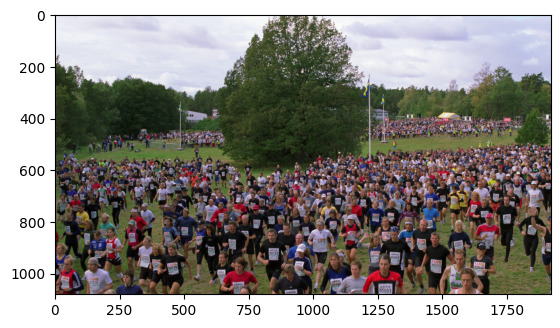

In [435]:
plt.imshow(next_odd[0].permute(1, 2, 0))

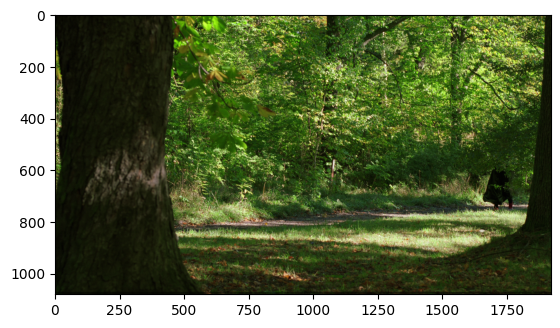

In [431]:
plt.imshow(cur_even[0].permute(1, 2, 0))

In [632]:
first, second = evaluate1(model, test_image)

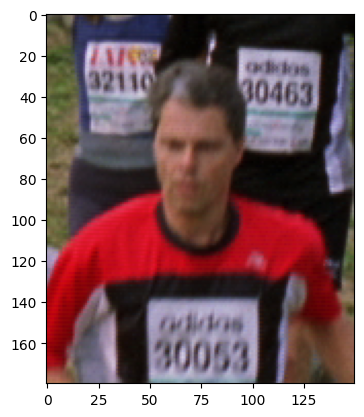

In [633]:
plt.imshow(first[900:1080, 1200:1350])

In [634]:
cv.imwrite("test.png", first)

True

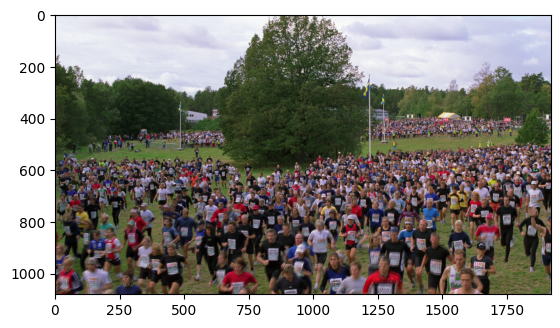

In [20]:
plt.imshow(test_image)

In [38]:
torch.from_numpy(test_image).size()

torch.Size([1080, 1920, 3])

In [272]:
first = np.zeros_like(test_image)
second = np.zeros_like(test_image)

first[::2] = test_image[::2]
second[1::2] = test_image[1::2]

In [ ]:
first, second = evaluate(model, test_image)

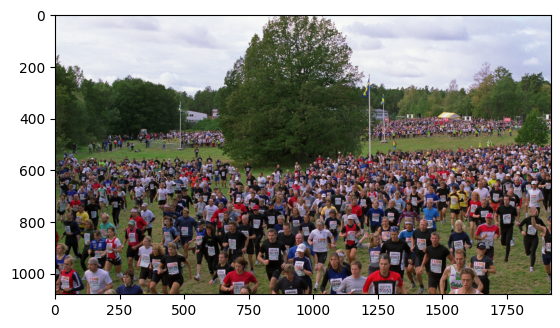

In [618]:
plt.imshow(first)

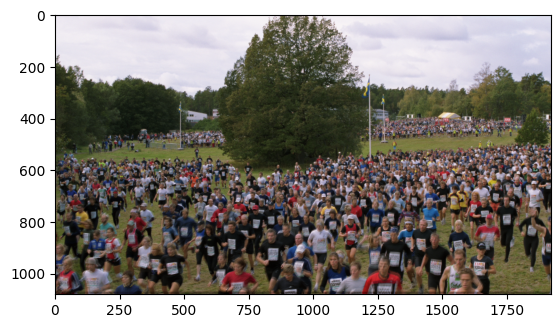

In [523]:
plt.imshow(second)

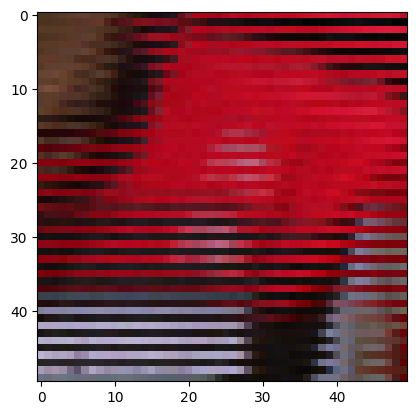

In [498]:
plt.imshow(test_image[1000:1050, 1275:1325])

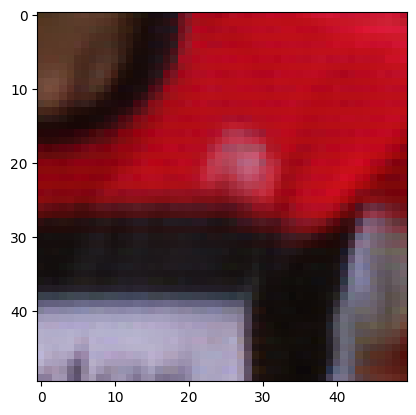

In [586]:
plt.imshow(first[1000 :1050 , 1275:1325])

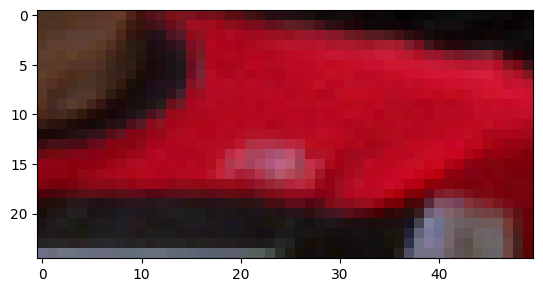

In [37]:
plt.imshow(second[1000 // 2:1050 // 2, 1275:1325])

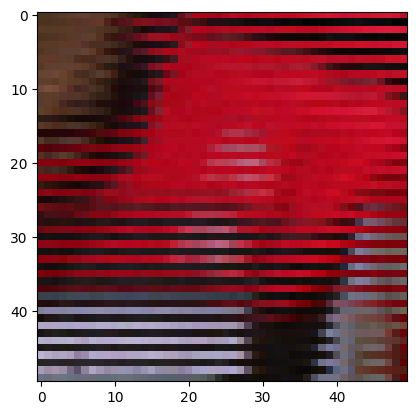

In [22]:
plt.imshow(test_image[1000:1050, 1275:1325])

In [504]:
# Сохраним полученную модель
torch.save(model, 'model.pth')

### 6. Протестируем полученную модель

Следующая ячейка должна вызывать вашу модель и получать из последовательности interlaced кадров deinterlaced кадры. Так же укажите относительный путь до сохранения в параметре model_path этой функции.

 - Комментарий `# GRADED CELL: ...` должен быть первым комментарием в клетке. Его нельзя изменять.
 - Эта клетка должен быть в единственном экземпляре.
 - Оцениваться будет только код, написанный внутри функции `test_model`.

In [622]:
# GRADED CELL: test_model
import cv2 as cv
def test_model(input_frames_dir, model_path='model.pth'):
    def evaluate1(model, interlaced_image):
        with torch.no_grad():
            model_input = torch.tensor(interlaced_image[np.newaxis, ...], device=device)
            # Predict

            size_of_blocks = (8, 8)
            size_of_domain = (32, 32)

            x = model_input.permute(0, 3, 1, 2)
            cur_even = torch.from_numpy(np.zeros_like(x.cpu()))
            next_odd = torch.from_numpy(np.zeros_like(x.cpu()))
            cur_even[:, :, 1::2] = x[:, :, 1::2]
            next_odd[:, :, ::2] = x[:, :, ::2]

            batch_size = x.size(dim=0)
            height = x.size(dim=2)
            width = x.size(dim=3)
            height_halves = height // 2
            mv_height = height_halves // size_of_blocks[0]
            mv_width = width // size_of_blocks[1]
            with torch.no_grad():
                cur = x[:, :, ::2]
                next = x[:, :, 1::2]
                for batch in range(batch_size):
                    for i in range(mv_height):
                        for j in range(mv_width):
                            #
                            block = cur[batch, :, i * size_of_blocks[0]:(i + 1) * size_of_blocks[0],
                                    j * size_of_blocks[1]:(j + 1) * size_of_blocks[1]]
                            domain = next[batch,
                                     :,
                                     max(0, i * size_of_blocks[0] + size_of_blocks[0]//2 - size_of_domain[0]):
                                     min(height_halves, (i + 1) * size_of_blocks[0] - size_of_blocks[0]//2 + size_of_domain[0]),
                                     max(0, j * size_of_blocks[1] + size_of_blocks[1]//2 - size_of_domain[1]):
                                     min(width, (j + 1) * size_of_blocks[1] - size_of_blocks[1]//2 + size_of_domain[1])
                                     ]
                            cmp_res = cv.matchTemplate(torch.Tensor.numpy(domain.permute(1, 2, 0).cpu()),
                                                       torch.Tensor.numpy(block.permute(1, 2, 0).cpu()),
                                                       cv.TM_SQDIFF)
                            i_r, j_r = cmp_res.argmin() // cmp_res[0].size, cmp_res.argmin() % cmp_res[0].size
                            next_odd[batch, :,
                            2 * i * size_of_blocks[0] + 1 : 2 * (i + 1) * size_of_blocks[0] + 1 : 2,
                            j * size_of_blocks[1]: (j + 1) * size_of_blocks[1]] = \
                                domain[:,
                                i_r : i_r + size_of_blocks[0],
                                j_r : j_r + size_of_blocks[1]]

                            block = next[batch, :, i * size_of_blocks[0]:(i + 1) * size_of_blocks[0],
                                    j * size_of_blocks[1]:(j + 1) * size_of_blocks[1]]
                            domain = cur[batch,
                                     :,
                                     max(0, i * size_of_blocks[0] + size_of_blocks[0]//2 - size_of_domain[0]):
                                     min(height_halves, (i + 1) * size_of_blocks[0] - size_of_blocks[0]//2 + size_of_domain[0]),
                                     max(0, j * size_of_blocks[1] + size_of_blocks[1]//2 - size_of_domain[1]):
                                     min(width, (j + 1) * size_of_blocks[1] - size_of_blocks[1]//2 + size_of_domain[1])
                                     ]
                            cmp_res = cv.matchTemplate(torch.Tensor.numpy(domain.permute(1, 2, 0).cpu()),
                                                       torch.Tensor.numpy(block.permute(1, 2, 0).cpu()),
                                                       cv.TM_SQDIFF)
                            i_r, j_r = cmp_res.argmin() // cmp_res[0].size, cmp_res.argmin() % cmp_res[0].size
                            cur_even[batch, :,
                            2 * i * size_of_blocks[0] : 2 * (i + 1) * size_of_blocks[0] : 2,
                            j * size_of_blocks[1]: (j + 1) * size_of_blocks[1]] = \
                                domain[:,
                                i_r : i_r + size_of_blocks[0],
                                j_r : j_r + size_of_blocks[1]]
                    for i in range(mv_height * size_of_blocks[0], height // 2):
                        next_odd[batch, :, 2 * i + 1, :] = next_odd[batch, :, 2 * i, :]
                        cur_even[batch, :, 2 * i, :] = cur_even[batch, :, 2 * i - 1, :]

            cur_even = cur_even.permute(0, 2, 3, 1)
            next_odd = next_odd.permute(0, 2, 3, 1)
            input_patches = torch.nn.utils.rnn.pad_sequence([next_odd, cur_even])
            input_patches.permute(1, 0, 2, 3, 4)
            current_even, next_odd = model(input_patches)

            current_even = current_even.cpu().numpy()[0]
            next_odd = next_odd.cpu().numpy()[0]

            first = np.zeros_like(interlaced_image)
            first[::2] = interlaced_image[::2]
            first[1::2] = current_even

            second = np.zeros_like(interlaced_image)
            second[1::2] = interlaced_image[1::2]
            second[::2] = next_odd
            return first, second
    """Calculates deinterlaced frames from interlaced

    Parameters
    ----------
        input_frames_dir : string
          path to interlaced framed
        model_path: sting 
          path to pytorch model

    Returns
    -------
        output_frames: list of deinterlaces frames
    """
    model = torch.load(model_path, map_location=torch.device('cpu')).to('cpu').eval()
    output_frames = []
    
    # If your model uses other inputs write an implementation of this function
    my_evaluate = evaluate1

    for input_name in sorted(os.listdir(input_frames_dir)):
        if '.DS_Store' in input_name:
            continue
        input_path = os.path.join(input_frames_dir, input_name)
        interlaced_frame = np.array(Image.open(input_path), dtype=np.float32) / 255.

        output_frames.extend(my_evaluate(model, interlaced_frame))
    return output_frames

In [623]:
model_outputs = test_model('C:/Users/doodo/Desktop/ИИТ/Task2/tiny_data/test/interlace/0')

KeyboardInterrupt: 

In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def calculate_metrics(model_outputs, gt_path):
    """Calculates average PSNR and SSIM on the passed data

    Parameters
    ----------
        model_outputs
            list of deinterlaced frames
        gt_path : string
            path to gt frames

    Returns
    -------
        (PSNR, SSIM)
    """
    gt_frames = [np.array(Image.open(os.path.join(gt_path, x)), dtype=np.float32) / 255. 
                 for x in sorted(os.listdir(gt_path)) if '.DS_Store' not in x]
    assert len(gt_frames) == len(model_outputs)
    ssim_list = []
    psnr_list = []
    for gt_frame, deinterlaced_frame in tqdm(zip(gt_frames, model_outputs)):
        ssim_list.append(ssim(gt_frame, deinterlaced_frame, multichannel=True))
        psnr_list.append(psnr(gt_frame, deinterlaced_frame))
    return np.mean(ssim_list), np.mean(psnr_list)

In [ ]:
calculate_metrics(model_outputs, 'C:/Users/doodo/Desktop/ИИТ/Task2/tiny_data/test/gt/0')